In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data=pd.read_csv('iris1.csv')
data.isnull().sum()

sepal_len    0
sepal_wid    0
petal_len    0
petal_wid    0
class        0
dtype: int64

In [2]:
print(data.shape)
print(data.info())

(150, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sepal_len  150 non-null    float64
 1   sepal_wid  150 non-null    float64
 2   petal_len  150 non-null    float64
 3   petal_wid  150 non-null    float64
 4   class      150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None


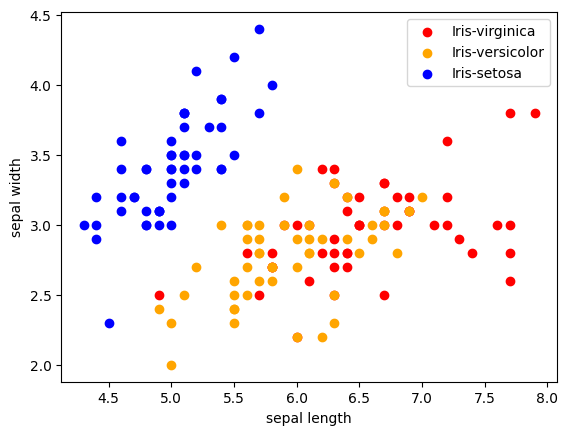

In [3]:
# scatter plot
colors=['red' , 'orange', 'blue']
species=['Iris-virginica','Iris-versicolor' ,'Iris-setosa']

for i in range(3):
    x=data[data['class'] ==species[i]]
    plt.scatter(x['sepal_len'], x['sepal_wid'] , c=colors[i] , label= species[i])
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

In [4]:
y = data['class']
y

0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
            ...      
145    Iris-virginica
146    Iris-virginica
147    Iris-virginica
148    Iris-virginica
149    Iris-virginica
Name: class, Length: 150, dtype: object

Decision Tree Results:
Accuracy: 0.73, Precision: 1.00, Recall: 0.73, F1 Score: 0.85


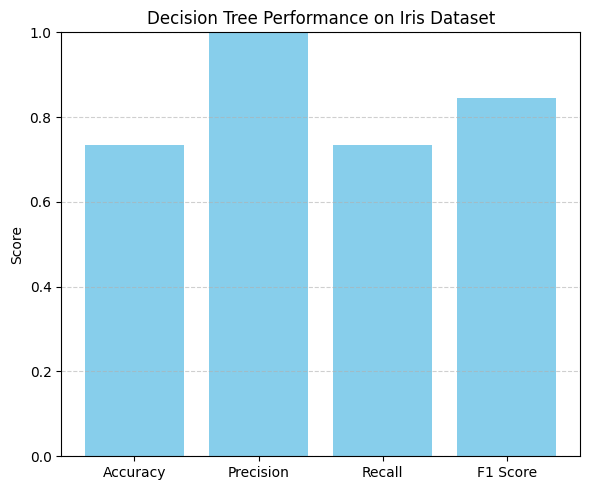

In [5]:
# decision Tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import math

columns = ['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']

# Step 2: Encode labels
label_map = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
data['class'] = data['class'].map(label_map)

# Step 3: Train-test split
features = ['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid']
x = data[features]
y = data['class']
split = int(0.8 * len(data))
train_data = data.iloc[:split]
test_data = data.iloc[split:]

# Step 4: Entropy
def entropy(y):
    total = len(y)
    counts = Counter(y)
    return -sum((c/total) * math.log2(c/total) for c in counts.values())

# Step 5: Best Split
def best_split(data):
    base_entropy = entropy(data['class'])
    best_gain = 0
    best_feature = None
    best_threshold = None

    for feature in data.columns[:-1]:
        values = sorted(data[feature].unique())
        for i in range(1, len(values)):
            threshold = (values[i-1] + values[i]) / 2
            left = data[data[feature] <= threshold]
            right = data[data[feature] > threshold]
            if len(left) == 0 or len(right) == 0:
                continue
            info = (len(left)/len(data)) * entropy(left['class']) + (len(right)/len(data)) * entropy(right['class'])
            gain = base_entropy - info
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold
    return best_feature, best_threshold

# Step 6: Build Tree
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def build_tree(data):
    y = data['class']
    if len(set(y)) == 1:
        return Node(value=y.iloc[0])
    if data.shape[1] == 1:
        return Node(value=Counter(y).most_common(1)[0][0])

    feature, threshold = best_split(data)
    if feature is None:
        return Node(value=Counter(y).most_common(1)[0][0])

    left_data = data[data[feature] <= threshold]
    right_data = data[data[feature] > threshold]
    left = build_tree(left_data)
    right = build_tree(right_data)
    return Node(feature, threshold, left, right)

# Step 7: Predict
def predict_tree(node, x):
    if node.value is not None:
        return node.value
    if x[node.feature] <= node.threshold:
        return predict_tree(node.left, x)
    else:
        return predict_tree(node.right, x)

tree = build_tree(train_data)

# Step 8: Predict on test data
y_pred_dt = [predict_tree(tree, row) for _, row in test_data.iterrows()]
y_true_dt = test_data['class'].tolist()

# Step 9: Evaluation
def evaluate(y_true, y_pred):
    accuracy = sum(y1 == y2 for y1, y2 in zip(y_true, y_pred)) / len(y_true)

    precision_list, recall_list, f1_list = [], [], []
    labels = np.unique(y_true)

    for label in labels:
        TP = sum((y_true[i] == label and y_pred[i] == label) for i in range(len(y_true)))
        FP = sum((y_true[i] != label and y_pred[i] == label) for i in range(len(y_true)))
        FN = sum((y_true[i] == label and y_pred[i] != label) for i in range(len(y_true)))

        precision = TP / (TP + FP + 1e-6)
        recall = TP / (TP + FN + 1e-6)
        f1 = 2 * precision * recall / (precision + recall + 1e-6)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    precision = np.mean(precision_list)
    recall = np.mean(recall_list)
    f1 = np.mean(f1_list)

    return accuracy, precision, recall, f1

acc_dt, pre_dt, rec_dt, f1_dt = evaluate(y_true_dt, y_pred_dt)

# Step 10: Print results
print("Decision Tree Results:")
print(f"Accuracy: {acc_dt:.2f}, Precision: {pre_dt:.2f}, Recall: {rec_dt:.2f}, F1 Score: {f1_dt:.2f}")

# Step 11: Visualization (Compare with dummy KNN & NB for reference)
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
dt_scores = [acc_dt, pre_dt, rec_dt, f1_dt]

plt.figure(figsize=(6, 5))
plt.bar(labels, dt_scores, color='skyblue')
plt.title('Decision Tree Performance on Iris Dataset')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
